In [230]:
from time import time
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import numpy as np
%matplotlib inline
from sklearn.manifold import TSNE

# Load data
with open("Fulldata.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    

In [231]:
#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 64)
validation_size = int(len(X_train) * 0.1)
training_size = len(X_train) - validation_size
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size,random_state= 64)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

In [232]:
print('Training size:',X_train.shape[0])
print('Validation size:',X_validation.shape[0])
print('test size:',X_test.shape[0])

Training size: 14400
Validation size: 1600
test size: 4000


In [233]:
#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [234]:
#Two help function
def one_hot(s):
    nb_digits=201
    batch_size = s.shape[0]
    seqlen = s.shape[1]
    s_onehot = torch.FloatTensor(batch_size,seqlen,nb_digits)
    s_onehot.zero_()
    s_onehot.scatter_(2, s.unsqueeze(2), 1)
    return s_onehot
def padding(data):
    left = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['left']))
        if diff>=1:
            data.iloc[i]['left']+= [0]*diff
        left.append((data.iloc[i]['left']))
    right = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['right']))
        if diff>=1:
            data.iloc[i]['right']+= [0]*diff
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)

In [235]:
#Padding and creat the loaders
X_train = padding(X_train)
Y_train = torch.FloatTensor(np.array(Y_train))
train_dataset  = Data.TensorDataset(X_train,Y_train)
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)

X_validation = padding(X_validation)
Y_validation = torch.FloatTensor(np.array(Y_validation))
val_dataset  = Data.TensorDataset(X_validation,Y_validation)

X_test = padding(X_test)
Y_test = torch.FloatTensor(np.array(Y_test))
test_dataset  = Data.TensorDataset(X_test,Y_test)

In [236]:
class LSTMEncoder(nn.Module):
    """ Implements the network type integrated within the Siamese RNN architecture. """
    def __init__(self, opt, is_train=False):
        super(LSTMEncoder, self).__init__()
        self.node_size = opt['node_size']
        self.name = 'sim_encoder'
        self.hidden_size= opt['hidden_size']
        self.num_layers= opt['num_layers']
        self.embedding_dim = opt['embedding_dim']
        self.bidirection_lstm = opt['bidirection_lstm']
        self.seqlen = opt['seqlen']
        self.batch_size = opt['batch_size']
        self.embedding_table = nn.Embedding(num_embeddings=self.node_size, embedding_dim=self.embedding_dim,
                                          padding_idx=0, max_norm=None, scale_grad_by_freq=False, sparse=False)
        self.lstm_rnn = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                                num_layers=self.num_layers,bidirectional=self.bidirection_lstm)
        if self.bidirection_lstm:
            fc_size1= self.hidden_size*self.seqlen*2
            fc_size2= 128
        else:
            fc_size1= self.hidden_size
            fc_size2= 16
        self.fc1= nn.Linear(fc_size1,fc_size2)
        self.fc2= nn.Linear(fc_size2,2)
        
    def initialize_hidden_plus_cell(self, batch_size):
        """ Re-initializes the hidden state, cell state, and the forget gate bias of the network. """
        if self.bidirection_lstm: 
            h0_size= self.num_layers*2
        else:
            h0_size= self.num_layers
        zero_hidden = torch.randn(h0_size, batch_size, self.hidden_size)
        zero_cell = torch.randn(h0_size, batch_size,self.hidden_size)
        return zero_hidden, zero_cell

    def forward(self, input_data, hidden, cell):
        """ Performs a forward pass through the network. """
        output = self.embedding_table(input_data)
        output, (hidden, cell) = self.lstm_rnn(output, (hidden, cell))
        #print(output.shape)
        #if self.bidirection_lstm:
        #    output = nn.functional.relu(self.fc1(output.transpose(1,0).contiguous().view(self.batch_size,-1)))
        #else:
        #    output = nn.functional.relu(self.fc1(output[-1]))
        #output = self.fc2(output) 
        return output[-1], hidden[-1], cell[-1]
    

In [237]:
class SiameseClassifier(nn.Module):
    """ Sentence similarity estimator implementing a siamese arcitecture. Uses pretrained word2vec embeddings. 
    Different to the paper, the weights are untied, to avoid exploding/ vanishing gradients. """
    def __init__(self, opt, is_train=False):
        super(SiameseClassifier, self).__init__()
        self.learning_rate= opt['learning_rate']
        # Initialize network
        self.encoder_a =  LSTMEncoder(opt, is_train)
        # Initialize network parameters
        self.initialize_parameters()
        # Declare loss function
        self.loss_function = nn.MSELoss()
        # Initialize network optimizers
        self.optimizer_a = optim.Adam(self.encoder_a.parameters(), lr=self.learning_rate,
                                      betas=(0.9, 0.999),weight_decay=0)
        

    def forward(self):
        """ Performs a single forward pass through the siamese architecture. """
        
        # Obtain the input length (each batch consists of padded sentences)
        input_length = self.batch_a.size(0)
        
        # Obtain sentence encodings from each encoder
        hidden_a, cell_a = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_a, hidden_a, cell_a = self.encoder_a(self.batch_a, hidden_a, cell_a)

        hidden_b, cell_b = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_b, hidden_b, cell_b = self.encoder_a(self.batch_b, hidden_b, cell_b)

        # Format sentence encodings as 2D tensors
        self.encoding_a = output_a.squeeze()
        self.encoding_b = output_b.squeeze()

        # Obtain similarity score predictions by calculating the Manhattan distance between sentence encodings
        if self.batch_size == 1:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1))
        else:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1, 1))
            

    def get_loss(self):
        """ Calculates the MSE loss between the network predictions and the ground truth. """
        # Loss is the L1 norm of the difference between the obtained sentence encodings
        self.loss = self.loss_function(self.prediction, self.labels)

    def load_pretrained_parameters(self,pretrained_state_dict_path):
        """ Loads the parameters learned during the pre-training on the SemEval data. """
        self.encoder_a.load_state_dict(torch.load(pretrained_state_dict_path))
        print('Pretrained parameters have been successfully loaded into the encoder networks.')
    
    def save_lstm(self,path):
        torch.save(self.encoder_a.state_dict(), path)

    def initialize_parameters(self):
        """ Initializes network parameters. """
        state_dict = self.encoder_a.state_dict()
        for key in state_dict.keys():
            if '.weight' in key:
                state_dict[key] = torch.nn.init.xavier_normal_((state_dict[key]),gain=1)
            if '.bias' in key:
                bias_length = state_dict[key].size()[0]
                start, end = bias_length // 4, bias_length // 2
                state_dict[key][start:end].fill_(2.5)
        self.encoder_a.load_state_dict(state_dict)
        
    def initialize_parametersX(self):
        for p in self.encoder_a.parameters():
            nn.init.xavier_normal_(p)

    def train_step(self, train_batch_a, train_batch_b, train_labels):
        """ Optimizes the parameters of the active networks, i.e. performs a single training step. """
        # Get batches
        self.batch_a = train_batch_a.transpose(0,1)
        self.batch_b = train_batch_b.transpose(0,1)
        self.labels = train_labels
        self.batch_size = self.batch_a.size(1)
        self.encoder_a.zero_grad() 
        self.forward()
        self.get_loss()
        #l2_reg = None
        #for i in classifier.encoder_a.lstm_rnn.parameters():
        #    if l2_reg is None:
        #        l2_reg = W.norm(2)
        #    else:
        #        l2_reg = l2_reg + W.norm(2)
        #self.loss += l2_reg
        self.loss.backward()
        clip_grad_norm(self.encoder_a.parameters(), 0.25)
        self.optimizer_a.step()

    def test_step(self, test_batch_a, test_batch_b, test_labels):
        """ Performs a single test step. """
        self.batch_a = test_batch_a.transpose(0,1)
        self.batch_b = test_batch_b.transpose(0,1)
        self.labels = test_labels
        self.batch_size = self.batch_a.size(1)
        self.forward()
        self.get_loss()

In [238]:
num_epochs = 50
pretrain=False

opt = {
    'node_size':201,
    'hidden_size':30,
    'num_layers':1,
    'embedding_dim':50,
    'learning_rate':0.0001,#10**np.random.uniform(-5, -3)
    'bidirection_lstm':False,
    'seqlen':50,
    'batch_size':32
}
print('learning_rate: ',opt['learning_rate'])

batch_size = opt['batch_size']
# Initialize global tracking variables
best_validation_accuracy = 0
epochs_without_improvement = 0
total_train_loss = list()
total_valid_loss = []
avg_trainings = []
avg_valids = []

# Loading model
if pretrain:
    classifier = torch.load('SiameseNN1.pt')
else:
    classifier = SiameseClassifier(opt, is_train=True)
    # Initialize parameters
    classifier.initialize_parameters()
    
for epoch in range(num_epochs):
    
    # Initiate the training data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    running_loss = list()
    # Training loop
    for i, (batch_x,label_var) in enumerate(train_loader):
        s1_var = batch_x[:,0,:]
        s2_var  = batch_x[:,1,:]
        #s1_var = one_hot(s1_var)
        #s2_var = one_hot(s2_var)
        classifier.train_step(s1_var, s2_var, label_var)
        train_batch_loss = classifier.loss.data[0]
        running_loss.append(train_batch_loss)
        total_train_loss.append(train_batch_loss)

        if i % 10 == 0 and i != 0:
            running_avg_loss = sum(running_loss) / len(running_loss)
            print('Epoch: %d | Training Batch: %d | Average loss: %.4f' %
                  (epoch, i , running_avg_loss))
            running_loss = []
            

    # Report epoch statistics
    avg_training_accuracy = sum(total_train_loss) / len(total_train_loss)
    print('Average training batch loss at epoch %d: %.4f' % (epoch, avg_training_accuracy))
    avg_trainings.append(avg_training_accuracy) 
    

    # Validate after each epoch; set tracking variables
    if epoch >= 0:
        # Initiate the training data loader
        valid_loader = DataLoader(val_dataset, batch_size=32,shuffle=True)
        
        # Validation loop (i.e. perform inference on the validation set)
        for i, (batch_x,label_var) in enumerate(valid_loader):
            s1_var = batch_x[:,0,:]
            s2_var  = batch_x[:,1,:]
            #s1_var = one_hot(s1_var)
            #s2_var = one_hot(s2_var)
            # Get predictions and update tracking values
            classifier.test_step(s1_var, s2_var, label_var)
            valid_batch_loss = classifier.loss.data[0]
            total_valid_loss.append(valid_batch_loss)

        # Report fold statistics
        avg_valid_accuracy = sum(total_valid_loss) / len(total_valid_loss)
        print('Average validation fold accuracy at epoch %d: %.4f' % (epoch, avg_valid_accuracy))
        avg_valids.append(avg_valid_accuracy)
        # Save network parameters if performance has improved
        if avg_valid_accuracy <= best_validation_accuracy:
            epochs_without_improvement += 1
        else:
            best_validation_accuracy = avg_valid_accuracy
            epochs_without_improvement = 0


learning_rate:  0.0001


/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Batch: 10 | Average loss: 0.4636
Epoch: 0 | Training Batch: 20 | Average loss: 0.4552
Epoch: 0 | Training Batch: 30 | Average loss: 0.4838
Epoch: 0 | Training Batch: 40 | Average loss: 0.4478
Epoch: 0 | Training Batch: 50 | Average loss: 0.4709
Epoch: 0 | Training Batch: 60 | Average loss: 0.4216
Epoch: 0 | Training Batch: 70 | Average loss: 0.4202
Epoch: 0 | Training Batch: 80 | Average loss: 0.3849
Epoch: 0 | Training Batch: 90 | Average loss: 0.3757
Epoch: 0 | Training Batch: 100 | Average loss: 0.3959
Epoch: 0 | Training Batch: 110 | Average loss: 0.3767
Epoch: 0 | Training Batch: 120 | Average loss: 0.3903
Epoch: 0 | Training Batch: 130 | Average loss: 0.3786
Epoch: 0 | Training Batch: 140 | Average loss: 0.3356
Epoch: 0 | Training Batch: 150 | Average loss: 0.3538
Epoch: 0 | Training Batch: 160 | Average loss: 0.3254
Epoch: 0 | Training Batch: 170 | Average loss: 0.3202
Epoch: 0 | Training Batch: 180 | Average loss: 0.3360
Epoch: 0 | Training Batch: 190 | Aver

/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average validation fold accuracy at epoch 0: 0.2896
Epoch: 1 | Training Batch: 10 | Average loss: 0.2752
Epoch: 1 | Training Batch: 20 | Average loss: 0.2893
Epoch: 1 | Training Batch: 30 | Average loss: 0.2895
Epoch: 1 | Training Batch: 40 | Average loss: 0.2707
Epoch: 1 | Training Batch: 50 | Average loss: 0.2669
Epoch: 1 | Training Batch: 60 | Average loss: 0.2896
Epoch: 1 | Training Batch: 70 | Average loss: 0.2617
Epoch: 1 | Training Batch: 80 | Average loss: 0.2746
Epoch: 1 | Training Batch: 90 | Average loss: 0.2839
Epoch: 1 | Training Batch: 100 | Average loss: 0.2705
Epoch: 1 | Training Batch: 110 | Average loss: 0.2960
Epoch: 1 | Training Batch: 120 | Average loss: 0.2671
Epoch: 1 | Training Batch: 130 | Average loss: 0.2860
Epoch: 1 | Training Batch: 140 | Average loss: 0.2862
Epoch: 1 | Training Batch: 150 | Average loss: 0.2780
Epoch: 1 | Training Batch: 160 | Average loss: 0.2654
Epoch: 1 | Training Batch: 170 | Average loss: 0.2812
Epoch: 1 | Training Batch: 180 | Averag

Epoch: 4 | Training Batch: 150 | Average loss: 0.2725
Epoch: 4 | Training Batch: 160 | Average loss: 0.2718
Epoch: 4 | Training Batch: 170 | Average loss: 0.2792
Epoch: 4 | Training Batch: 180 | Average loss: 0.2759
Epoch: 4 | Training Batch: 190 | Average loss: 0.2586
Epoch: 4 | Training Batch: 200 | Average loss: 0.2647
Epoch: 4 | Training Batch: 210 | Average loss: 0.2771
Epoch: 4 | Training Batch: 220 | Average loss: 0.2632
Epoch: 4 | Training Batch: 230 | Average loss: 0.2757
Epoch: 4 | Training Batch: 240 | Average loss: 0.2756
Epoch: 4 | Training Batch: 250 | Average loss: 0.2742
Epoch: 4 | Training Batch: 260 | Average loss: 0.2742
Epoch: 4 | Training Batch: 270 | Average loss: 0.2692
Epoch: 4 | Training Batch: 280 | Average loss: 0.2798
Epoch: 4 | Training Batch: 290 | Average loss: 0.2735
Epoch: 4 | Training Batch: 300 | Average loss: 0.2641
Epoch: 4 | Training Batch: 310 | Average loss: 0.2673
Epoch: 4 | Training Batch: 320 | Average loss: 0.2670
Epoch: 4 | Training Batch: 3

Epoch: 7 | Training Batch: 300 | Average loss: 0.2605
Epoch: 7 | Training Batch: 310 | Average loss: 0.2684
Epoch: 7 | Training Batch: 320 | Average loss: 0.2532
Epoch: 7 | Training Batch: 330 | Average loss: 0.2636
Epoch: 7 | Training Batch: 340 | Average loss: 0.2712
Epoch: 7 | Training Batch: 350 | Average loss: 0.2720
Epoch: 7 | Training Batch: 360 | Average loss: 0.2671
Epoch: 7 | Training Batch: 370 | Average loss: 0.2734
Epoch: 7 | Training Batch: 380 | Average loss: 0.2503
Epoch: 7 | Training Batch: 390 | Average loss: 0.2627
Epoch: 7 | Training Batch: 400 | Average loss: 0.2581
Epoch: 7 | Training Batch: 410 | Average loss: 0.2668
Epoch: 7 | Training Batch: 420 | Average loss: 0.2591
Epoch: 7 | Training Batch: 430 | Average loss: 0.2650
Epoch: 7 | Training Batch: 440 | Average loss: 0.2642
Average training batch loss at epoch 7: 0.2765
Average validation fold accuracy at epoch 7: 0.2688
Epoch: 8 | Training Batch: 10 | Average loss: 0.2636
Epoch: 8 | Training Batch: 20 | Averag

Epoch: 10 | Training Batch: 440 | Average loss: 0.2646
Average training batch loss at epoch 10: 0.2724
Average validation fold accuracy at epoch 10: 0.2661
Epoch: 11 | Training Batch: 10 | Average loss: 0.2617
Epoch: 11 | Training Batch: 20 | Average loss: 0.2641
Epoch: 11 | Training Batch: 30 | Average loss: 0.2598
Epoch: 11 | Training Batch: 40 | Average loss: 0.2624
Epoch: 11 | Training Batch: 50 | Average loss: 0.2552
Epoch: 11 | Training Batch: 60 | Average loss: 0.2455
Epoch: 11 | Training Batch: 70 | Average loss: 0.2626
Epoch: 11 | Training Batch: 80 | Average loss: 0.2501
Epoch: 11 | Training Batch: 90 | Average loss: 0.2604
Epoch: 11 | Training Batch: 100 | Average loss: 0.2636
Epoch: 11 | Training Batch: 110 | Average loss: 0.2565
Epoch: 11 | Training Batch: 120 | Average loss: 0.2559
Epoch: 11 | Training Batch: 130 | Average loss: 0.2658
Epoch: 11 | Training Batch: 140 | Average loss: 0.2533
Epoch: 11 | Training Batch: 150 | Average loss: 0.2557
Epoch: 11 | Training Batch: 

Epoch: 14 | Training Batch: 110 | Average loss: 0.2588
Epoch: 14 | Training Batch: 120 | Average loss: 0.2635
Epoch: 14 | Training Batch: 130 | Average loss: 0.2549
Epoch: 14 | Training Batch: 140 | Average loss: 0.2600
Epoch: 14 | Training Batch: 150 | Average loss: 0.2569
Epoch: 14 | Training Batch: 160 | Average loss: 0.2552
Epoch: 14 | Training Batch: 170 | Average loss: 0.2683
Epoch: 14 | Training Batch: 180 | Average loss: 0.2714
Epoch: 14 | Training Batch: 190 | Average loss: 0.2538
Epoch: 14 | Training Batch: 200 | Average loss: 0.2627
Epoch: 14 | Training Batch: 210 | Average loss: 0.2638
Epoch: 14 | Training Batch: 220 | Average loss: 0.2559
Epoch: 14 | Training Batch: 230 | Average loss: 0.2651
Epoch: 14 | Training Batch: 240 | Average loss: 0.2520
Epoch: 14 | Training Batch: 250 | Average loss: 0.2561
Epoch: 14 | Training Batch: 260 | Average loss: 0.2551
Epoch: 14 | Training Batch: 270 | Average loss: 0.2661
Epoch: 14 | Training Batch: 280 | Average loss: 0.2635
Epoch: 14 

Epoch: 17 | Training Batch: 230 | Average loss: 0.2533
Epoch: 17 | Training Batch: 240 | Average loss: 0.2625
Epoch: 17 | Training Batch: 250 | Average loss: 0.2554
Epoch: 17 | Training Batch: 260 | Average loss: 0.2665
Epoch: 17 | Training Batch: 270 | Average loss: 0.2535
Epoch: 17 | Training Batch: 280 | Average loss: 0.2581
Epoch: 17 | Training Batch: 290 | Average loss: 0.2694
Epoch: 17 | Training Batch: 300 | Average loss: 0.2467
Epoch: 17 | Training Batch: 310 | Average loss: 0.2537
Epoch: 17 | Training Batch: 320 | Average loss: 0.2448
Epoch: 17 | Training Batch: 330 | Average loss: 0.2540
Epoch: 17 | Training Batch: 340 | Average loss: 0.2549
Epoch: 17 | Training Batch: 350 | Average loss: 0.2520
Epoch: 17 | Training Batch: 360 | Average loss: 0.2639
Epoch: 17 | Training Batch: 370 | Average loss: 0.2630
Epoch: 17 | Training Batch: 380 | Average loss: 0.2622
Epoch: 17 | Training Batch: 390 | Average loss: 0.2630
Epoch: 17 | Training Batch: 400 | Average loss: 0.2638
Epoch: 17 

Epoch: 20 | Training Batch: 350 | Average loss: 0.2582
Epoch: 20 | Training Batch: 360 | Average loss: 0.2591
Epoch: 20 | Training Batch: 370 | Average loss: 0.2535
Epoch: 20 | Training Batch: 380 | Average loss: 0.2602
Epoch: 20 | Training Batch: 390 | Average loss: 0.2571
Epoch: 20 | Training Batch: 400 | Average loss: 0.2621
Epoch: 20 | Training Batch: 410 | Average loss: 0.2586
Epoch: 20 | Training Batch: 420 | Average loss: 0.2503
Epoch: 20 | Training Batch: 430 | Average loss: 0.2584
Epoch: 20 | Training Batch: 440 | Average loss: 0.2591
Average training batch loss at epoch 20: 0.2658
Average validation fold accuracy at epoch 20: 0.2626
Epoch: 21 | Training Batch: 10 | Average loss: 0.2559
Epoch: 21 | Training Batch: 20 | Average loss: 0.2630
Epoch: 21 | Training Batch: 30 | Average loss: 0.2511
Epoch: 21 | Training Batch: 40 | Average loss: 0.2510
Epoch: 21 | Training Batch: 50 | Average loss: 0.2514
Epoch: 21 | Training Batch: 60 | Average loss: 0.2611
Epoch: 21 | Training Batc

Epoch: 24 | Training Batch: 20 | Average loss: 0.2573
Epoch: 24 | Training Batch: 30 | Average loss: 0.2601
Epoch: 24 | Training Batch: 40 | Average loss: 0.2592
Epoch: 24 | Training Batch: 50 | Average loss: 0.2471
Epoch: 24 | Training Batch: 60 | Average loss: 0.2595
Epoch: 24 | Training Batch: 70 | Average loss: 0.2456
Epoch: 24 | Training Batch: 80 | Average loss: 0.2547
Epoch: 24 | Training Batch: 90 | Average loss: 0.2573
Epoch: 24 | Training Batch: 100 | Average loss: 0.2589
Epoch: 24 | Training Batch: 110 | Average loss: 0.2626
Epoch: 24 | Training Batch: 120 | Average loss: 0.2570
Epoch: 24 | Training Batch: 130 | Average loss: 0.2519
Epoch: 24 | Training Batch: 140 | Average loss: 0.2653
Epoch: 24 | Training Batch: 150 | Average loss: 0.2660
Epoch: 24 | Training Batch: 160 | Average loss: 0.2537
Epoch: 24 | Training Batch: 170 | Average loss: 0.2615
Epoch: 24 | Training Batch: 180 | Average loss: 0.2508
Epoch: 24 | Training Batch: 190 | Average loss: 0.2559
Epoch: 24 | Traini

Epoch: 27 | Training Batch: 150 | Average loss: 0.2579
Epoch: 27 | Training Batch: 160 | Average loss: 0.2565
Epoch: 27 | Training Batch: 170 | Average loss: 0.2561
Epoch: 27 | Training Batch: 180 | Average loss: 0.2560
Epoch: 27 | Training Batch: 190 | Average loss: 0.2574
Epoch: 27 | Training Batch: 200 | Average loss: 0.2564
Epoch: 27 | Training Batch: 210 | Average loss: 0.2615
Epoch: 27 | Training Batch: 220 | Average loss: 0.2569
Epoch: 27 | Training Batch: 230 | Average loss: 0.2579
Epoch: 27 | Training Batch: 240 | Average loss: 0.2567
Epoch: 27 | Training Batch: 250 | Average loss: 0.2575
Epoch: 27 | Training Batch: 260 | Average loss: 0.2465
Epoch: 27 | Training Batch: 270 | Average loss: 0.2546
Epoch: 27 | Training Batch: 280 | Average loss: 0.2575
Epoch: 27 | Training Batch: 290 | Average loss: 0.2604
Epoch: 27 | Training Batch: 300 | Average loss: 0.2534
Epoch: 27 | Training Batch: 310 | Average loss: 0.2620
Epoch: 27 | Training Batch: 320 | Average loss: 0.2613
Epoch: 27 

Epoch: 30 | Training Batch: 270 | Average loss: 0.2484
Epoch: 30 | Training Batch: 280 | Average loss: 0.2527
Epoch: 30 | Training Batch: 290 | Average loss: 0.2608
Epoch: 30 | Training Batch: 300 | Average loss: 0.2631
Epoch: 30 | Training Batch: 310 | Average loss: 0.2578
Epoch: 30 | Training Batch: 320 | Average loss: 0.2580
Epoch: 30 | Training Batch: 330 | Average loss: 0.2499
Epoch: 30 | Training Batch: 340 | Average loss: 0.2568
Epoch: 30 | Training Batch: 350 | Average loss: 0.2569
Epoch: 30 | Training Batch: 360 | Average loss: 0.2509
Epoch: 30 | Training Batch: 370 | Average loss: 0.2559
Epoch: 30 | Training Batch: 380 | Average loss: 0.2492
Epoch: 30 | Training Batch: 390 | Average loss: 0.2587
Epoch: 30 | Training Batch: 400 | Average loss: 0.2601
Epoch: 30 | Training Batch: 410 | Average loss: 0.2526
Epoch: 30 | Training Batch: 420 | Average loss: 0.2530
Epoch: 30 | Training Batch: 430 | Average loss: 0.2547
Epoch: 30 | Training Batch: 440 | Average loss: 0.2582
Average tr

Epoch: 33 | Training Batch: 390 | Average loss: 0.2541
Epoch: 33 | Training Batch: 400 | Average loss: 0.2599
Epoch: 33 | Training Batch: 410 | Average loss: 0.2549
Epoch: 33 | Training Batch: 420 | Average loss: 0.2528
Epoch: 33 | Training Batch: 430 | Average loss: 0.2501
Epoch: 33 | Training Batch: 440 | Average loss: 0.2496
Average training batch loss at epoch 33: 0.2619
Average validation fold accuracy at epoch 33: 0.2603
Epoch: 34 | Training Batch: 10 | Average loss: 0.2539
Epoch: 34 | Training Batch: 20 | Average loss: 0.2580
Epoch: 34 | Training Batch: 30 | Average loss: 0.2565
Epoch: 34 | Training Batch: 40 | Average loss: 0.2492
Epoch: 34 | Training Batch: 50 | Average loss: 0.2544
Epoch: 34 | Training Batch: 60 | Average loss: 0.2593
Epoch: 34 | Training Batch: 70 | Average loss: 0.2553
Epoch: 34 | Training Batch: 80 | Average loss: 0.2563
Epoch: 34 | Training Batch: 90 | Average loss: 0.2523
Epoch: 34 | Training Batch: 100 | Average loss: 0.2646
Epoch: 34 | Training Batch: 

Epoch: 37 | Training Batch: 60 | Average loss: 0.2499
Epoch: 37 | Training Batch: 70 | Average loss: 0.2589
Epoch: 37 | Training Batch: 80 | Average loss: 0.2541
Epoch: 37 | Training Batch: 90 | Average loss: 0.2542
Epoch: 37 | Training Batch: 100 | Average loss: 0.2535
Epoch: 37 | Training Batch: 110 | Average loss: 0.2457
Epoch: 37 | Training Batch: 120 | Average loss: 0.2493
Epoch: 37 | Training Batch: 130 | Average loss: 0.2483
Epoch: 37 | Training Batch: 140 | Average loss: 0.2564
Epoch: 37 | Training Batch: 150 | Average loss: 0.2533
Epoch: 37 | Training Batch: 160 | Average loss: 0.2582
Epoch: 37 | Training Batch: 170 | Average loss: 0.2572
Epoch: 37 | Training Batch: 180 | Average loss: 0.2559
Epoch: 37 | Training Batch: 190 | Average loss: 0.2574
Epoch: 37 | Training Batch: 200 | Average loss: 0.2529
Epoch: 37 | Training Batch: 210 | Average loss: 0.2583
Epoch: 37 | Training Batch: 220 | Average loss: 0.2513
Epoch: 37 | Training Batch: 230 | Average loss: 0.2570
Epoch: 37 | Tr

Epoch: 40 | Training Batch: 190 | Average loss: 0.2488
Epoch: 40 | Training Batch: 200 | Average loss: 0.2650
Epoch: 40 | Training Batch: 210 | Average loss: 0.2499
Epoch: 40 | Training Batch: 220 | Average loss: 0.2574
Epoch: 40 | Training Batch: 230 | Average loss: 0.2571
Epoch: 40 | Training Batch: 240 | Average loss: 0.2554
Epoch: 40 | Training Batch: 250 | Average loss: 0.2551
Epoch: 40 | Training Batch: 260 | Average loss: 0.2492
Epoch: 40 | Training Batch: 270 | Average loss: 0.2514
Epoch: 40 | Training Batch: 280 | Average loss: 0.2525
Epoch: 40 | Training Batch: 290 | Average loss: 0.2574
Epoch: 40 | Training Batch: 300 | Average loss: 0.2559
Epoch: 40 | Training Batch: 310 | Average loss: 0.2543
Epoch: 40 | Training Batch: 320 | Average loss: 0.2496
Epoch: 40 | Training Batch: 330 | Average loss: 0.2592
Epoch: 40 | Training Batch: 340 | Average loss: 0.2547
Epoch: 40 | Training Batch: 350 | Average loss: 0.2537
Epoch: 40 | Training Batch: 360 | Average loss: 0.2557
Epoch: 40 

Epoch: 43 | Training Batch: 310 | Average loss: 0.2528
Epoch: 43 | Training Batch: 320 | Average loss: 0.2505
Epoch: 43 | Training Batch: 330 | Average loss: 0.2587
Epoch: 43 | Training Batch: 340 | Average loss: 0.2551
Epoch: 43 | Training Batch: 350 | Average loss: 0.2471
Epoch: 43 | Training Batch: 360 | Average loss: 0.2535
Epoch: 43 | Training Batch: 370 | Average loss: 0.2581
Epoch: 43 | Training Batch: 380 | Average loss: 0.2503
Epoch: 43 | Training Batch: 390 | Average loss: 0.2502
Epoch: 43 | Training Batch: 400 | Average loss: 0.2471
Epoch: 43 | Training Batch: 410 | Average loss: 0.2474
Epoch: 43 | Training Batch: 420 | Average loss: 0.2501
Epoch: 43 | Training Batch: 430 | Average loss: 0.2507
Epoch: 43 | Training Batch: 440 | Average loss: 0.2533
Average training batch loss at epoch 43: 0.2600
Average validation fold accuracy at epoch 43: 0.2592
Epoch: 44 | Training Batch: 10 | Average loss: 0.2550
Epoch: 44 | Training Batch: 20 | Average loss: 0.2562
Epoch: 44 | Training 

Epoch: 46 | Training Batch: 430 | Average loss: 0.2496
Epoch: 46 | Training Batch: 440 | Average loss: 0.2558
Average training batch loss at epoch 46: 0.2596
Average validation fold accuracy at epoch 46: 0.2588
Epoch: 47 | Training Batch: 10 | Average loss: 0.2572
Epoch: 47 | Training Batch: 20 | Average loss: 0.2502
Epoch: 47 | Training Batch: 30 | Average loss: 0.2493
Epoch: 47 | Training Batch: 40 | Average loss: 0.2530
Epoch: 47 | Training Batch: 50 | Average loss: 0.2470
Epoch: 47 | Training Batch: 60 | Average loss: 0.2483
Epoch: 47 | Training Batch: 70 | Average loss: 0.2487
Epoch: 47 | Training Batch: 80 | Average loss: 0.2513
Epoch: 47 | Training Batch: 90 | Average loss: 0.2554
Epoch: 47 | Training Batch: 100 | Average loss: 0.2516
Epoch: 47 | Training Batch: 110 | Average loss: 0.2562
Epoch: 47 | Training Batch: 120 | Average loss: 0.2540
Epoch: 47 | Training Batch: 130 | Average loss: 0.2547
Epoch: 47 | Training Batch: 140 | Average loss: 0.2499
Epoch: 47 | Training Batch: 

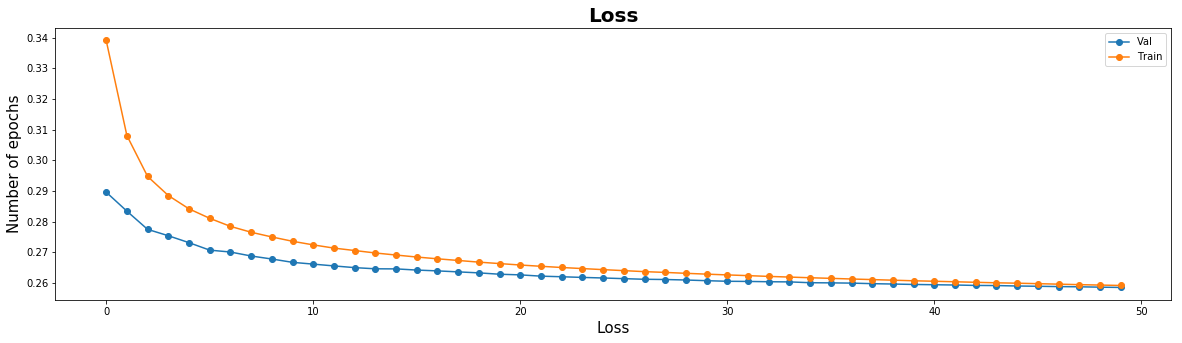

In [239]:
fig, ax = plt.subplots(figsize= (20,5))
ax.plot(avg_valids,marker='o',label='Val')
ax.plot(avg_trainings,marker='o',label='Train')
ax.set_xlabel('Loss',fontsize=15)
ax.set_ylabel('Number of epochs',fontsize=15)
ax.set_title('Loss',fontsize=20,fontweight ="bold")
ax.legend()
graph_path = "./Pytorch_Results/FullDataOnlyLSTM1lr" + str(opt['learning_rate']) +'.png'
fig.savefig(graph_path)

In [240]:
model_path = "./Pytorch_Model/FullDataOnlyLSTM1lr" + str(opt['learning_rate']) +'.pt'
torch.save(classifier, model_path)

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTMEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [107]:
classifier.encoder_a.state_dict().keys()

odict_keys(['embedding_table.weight', 'lstm_rnn.weight_ih_l0', 'lstm_rnn.weight_hh_l0', 'lstm_rnn.bias_ih_l0', 'lstm_rnn.bias_hh_l0', 'lstm_rnn.weight_ih_l1', 'lstm_rnn.weight_hh_l1', 'lstm_rnn.bias_ih_l1', 'lstm_rnn.bias_hh_l1', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [142]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print("number of parameters in this model: ",get_n_params(classifier))

number of parameters in this model:  27860


'./Pytorch_Results/OnlyLSTM1lr9.708935755359682e-05.png'